Ссылка на презентацию:
https://disk.yandex.ru/i/JRe0qUUQRQ5gFA

# Выявление профилей потребления

**Описание проекта:**  
Заказчик - интернет-магазин товаров для дома «Пока все ещё тут». Необходимо сегментировать покупателей по профилю потребления на основе истории их покупок для разработки персонализированных рекламных рассылок.


# Ход работы

**Шаг 1. Обзор данных и предобработка**
+ Ознакомиться с данными  
+ Проверить данные на наличие пропусков и дубликатов (явных и неявных)     
+ Проверить типы данных  

**Шаг 2. Исследовательский анализ**
+ Данными за какой период мы располагаем?
+ Какое количество заказов за этот период?
+ Какое количество покупателей за этот период?
+ Количество заказов ежемесячно
+ В какой день недели чаще всего заказывают?
+ Сколько заказов в среднем совершает один покупатель?
+ Проверить данные на наличие аномалий 
+ Изучить выручку и средний чек  
+ Изучить ассортимент магазина, выделить основные товарные категории  
+ Какова доля каждой категории?  
+ Как меняются продажи категорий в зависимости от месяца?  
 


**Шаг 3. Сегментация покупателей на основе истории их покупок**
+ Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры покупателей  
  
**Шаг 4. Статистический анализ**  
+ Гипотеза о равенстве выручки между сегментами покупателей  
  + *H0* - Нет статистически значимых различий между сегментами покупателей  
  + *H1* - Есть статистически значимые различия между сегментами покупателей 
+ Гипотеза о равенстве среднего чека между сегментами покупателе
  + *H0* - Нет статистически значимых различий между сегментами покупателей  
  + *H1* - Есть статистически значимые различия между сегментами покупателей 

**Шаг 5. Подведение итогов**
+ Общие выводы и рекомендации для заказчика

# Описание данных:  
Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока
все ещё тут».  

`date` — дата заказа;  
`customer_id` — идентификатор покупателя;  
`order_id` — идентификатор заказа;  
`product` — наименование товара;  
`quantity` — количество товара в заказе;  
`price` — цена товара.  

In [1]:
import pandas as pd
import numpy as np

from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from pymystem3 import Mystem
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

In [2]:
pd.set_option('display.max_columns', None)

## Обзор данных и предобработка

In [3]:
def bold_text(text):
    '''
    функция для жирного шрифта
    '''
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    return bold_start + text + bold_end

def dataframe_overview (data):
    '''
    функция для ознакомления с набором данных
    '''
    print(bold_text('Первые 10 строк'))
    print('')
    display(data.head(10))
    print(bold_text('Последние 10 строк'))
    print('')
    display(data.tail(10))
    print(bold_text('Типы данных'))
    print('')
    display(data.info())
    print(bold_text('Статистика'))
    print('')
    display(data.describe())
    print(bold_text('Пропуски'))
    print('')
    display(data.isna().sum())
    print(bold_text('Доля пропущенных значений'))
    print('')
    display(data.isna().mean().sort_values(ascending=False)*100)
    print(bold_text('Полные дубликаты:'))
    print('')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов не обнаружено')

In [4]:
path = 'C:/Users/sdibi/Documents/Dataset/'
try:
    df =  pd.read_csv(path + 'ecom_dataset_upd.csv')
except:
    df =  pd.read_csv('/datasets/ecom_dataset_upd.csv')

In [5]:
#ознакомимся с данными
dataframe_overview(df)

Первые 10 строк



,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


Последние 10 строк



,date,customer_id,order_id,product,quantity,price
7464,2020012913,28437f82-c2a8-41ea-a7c1-bcedece59d8b,102658,"Гладильная доска НИКА 3+ 122х34,5 см Н3+",1,1124.0
7465,2020012913,0b2157e5-101e-4e0e-bfaf-7340ed23e574,111547,"Коврик придверный, полипропилен, 40х70 см, Kok...",1,749.0
7466,2020012914,904015ba-31f2-4ce4-b68e-02362280a43d,107214,Ящик почтовый металлический с ушками для навес...,1,172.0
7467,2020012917,4228e34b-dcba-4df8-ae70-b282e84a1edb,110547,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,1,2399.0
7468,2020013008,370ed405-57f6-4eff-ab2e-a0bacab6e982,102891,Пеларгония зональная Ринго Вайт d-7 см h-10 см...,1,74.0
7469,2020013021,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0
7470,2020013022,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
7471,2020013102,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0
7472,2020013112,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0
7473,2020013115,2e460a26-35af-453d-a369-a036e95a40e0,103225,Вешалка для блузок 41 см красный Attribute AHM781,1,104.0


Типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


None

Статистика



,date,order_id,quantity,price
count,7.474000e+03,7474.000000,7474.000000,7474.000000
mean,2.018913e+09,49449.884265,2.362858,478.737501
std,4.278878e+05,32679.642404,14.500497,901.615895
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019022e+09,14833.000000,1.000000,97.000000
50%,2.019051e+09,68768.000000,1.000000,135.000000
75%,2.019063e+09,71257.750000,1.000000,439.000000
max,2.020013e+09,112789.000000,1000.000000,14917.000000


Пропуски



date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Доля пропущенных значений



date           0.0
customer_id    0.0
order_id       0.0
product        0.0
quantity       0.0
price          0.0
dtype: float64

Полные дубликаты:

Дубликатов не обнаружено


**В ходе первичного ознакомления с данными было выявлено:**  
+ типы данных соответствуют содержимому во всех столбцах, кроме `date`  
+ полных дубликатов не обнаружено  
+ пропусков в данных нет  

In [6]:
#проверим данные на неявные дубликаты
df['product'] = df['product'].str.lower()
df['product'] = df['product'].replace('ё', 'е', regex=True)

print(bold_text('Количество дубликатов:'),
      df[['customer_id', 'order_id', 'product']].duplicated().sum()
     )
print (bold_text('Процент дубликатов в датасете:'),
       round(
           df[['customer_id', 'order_id', 'product']].duplicated().sum()/df.shape[0] * 100,
           2)
      )


Количество дубликатов: 1886
Процент дубликатов в датасете: 25.23


Обнаружено 1886 неявных дубликата, что составляет 25% от всех данных. Придется удалить строки с дубликатами, иначе они могут исказить результаты. 

In [7]:
df = df.drop_duplicates(subset = ['customer_id', 'order_id', 'product']).reset_index(drop= True)

Проверим, нет ли в данных заказов, которым соответсвует сразу несколько покупателей.

In [8]:
multiple_users = df.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False).reset_index()
multiple_users[multiple_users['customer_id'] > 1]['order_id']

0     72845
1     71480
2     69485
3     69410
4     71226
5     69283
6     72950
7     70631
8     69531
9     69833
10    70946
11    70808
12    71054
13    69345
14    72778
15    72188
16    71542
17    68785
18    69310
19    71571
20    72790
21    70114
22    14872
23    71663
24    70726
25    71461
26    70903
27    70542
28    71648
Name: order_id, dtype: int64

Обнаружили, что 29 заказов соответсвует сразу нескольким пользователям. Удалим строки с этими заказами.

In [9]:
df = df.drop(df[df['order_id'].isin(multiple_users[multiple_users['customer_id'] > 1]['order_id'])].index, axis=0)

In [10]:
#приведем дату к нужному типу
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H') 

#созадим столбец с годом
df['year'] = df['date'].dt.year

#созадим столбец с названием месяца
df['month'] = df['date'].dt.month

#созадим столбец с днём недели
df['weekday'] = df['date'].dt.dayofweek

#создадим столбец с суммой заказа
df['total'] = round(df['price'] * df['quantity'], 2)

**В ходе предобработки были внесены следующие изменения:**  
+ удалены 1886 дубликата  
+ изменен тип данных в столбце `date`  
+ созданы столбцы `year`, `month` и `weekday` с указанием года, месяца и дня недели  
+ создан столбец `total` с выручкой с каждого заказа

## Исследовательский анализ

### Данными за какой период мы располагаем?

In [11]:
print(bold_text('Мы располагаем данными за период с'), df['date'].min(), bold_text('по'), df['date'].max())

Мы располагаем данными за период с 2018-10-01 00:00:00 по 2020-01-31 15:00:00


В нашем распоряжении информация за **1 год и 4 месяца**

### Какое количество покупателей и заказов за этот период?

In [12]:
print(bold_text('Количество покупателей:'), df['customer_id'].nunique())
print(bold_text('Количество заказов:'), df['order_id'].nunique())

Количество покупателей: 2413
Количество заказов: 3492


### Количество заказов ежемесячно

In [13]:
sns.set(font_scale=1.2, style='whitegrid')
sns.set_palette('bright')

(array([17836., 17897., 17956., 18017., 18078., 18140., 18201., 18262.]),
 [Text(17836.0, 0, '2018-11'),
  Text(17897.0, 0, '2019-01'),
  Text(17956.0, 0, '2019-03'),
  Text(18017.0, 0, '2019-05'),
  Text(18078.0, 0, '2019-07'),
  Text(18140.0, 0, '2019-09'),
  Text(18201.0, 0, '2019-11'),
  Text(18262.0, 0, '2020-01')])

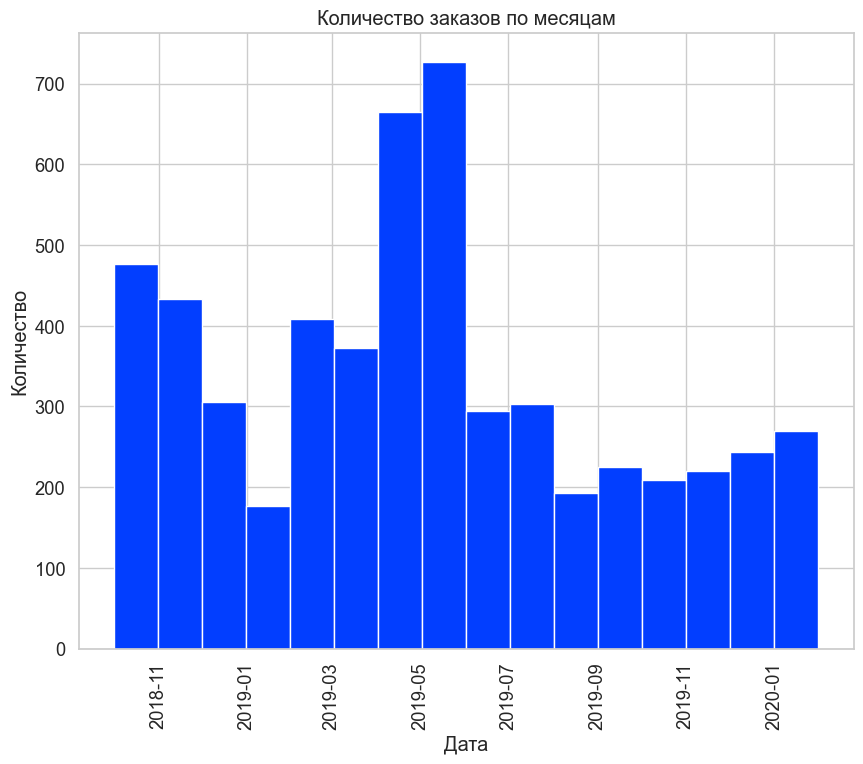

In [14]:
plt.figure(figsize=(10, 8))
df['date'].hist(bins=16)
plt.title('Количество заказов по месяцам')
plt.xlabel('Дата')  
plt.ylabel('Количество')
plt.xticks(rotation=90)

На графике наблюдается пик в апреле и мае 2019 года, после которого количество заказов заметно снизилось по сравнению с первоначальным.

### В какой день недели чаще всего заказывают?

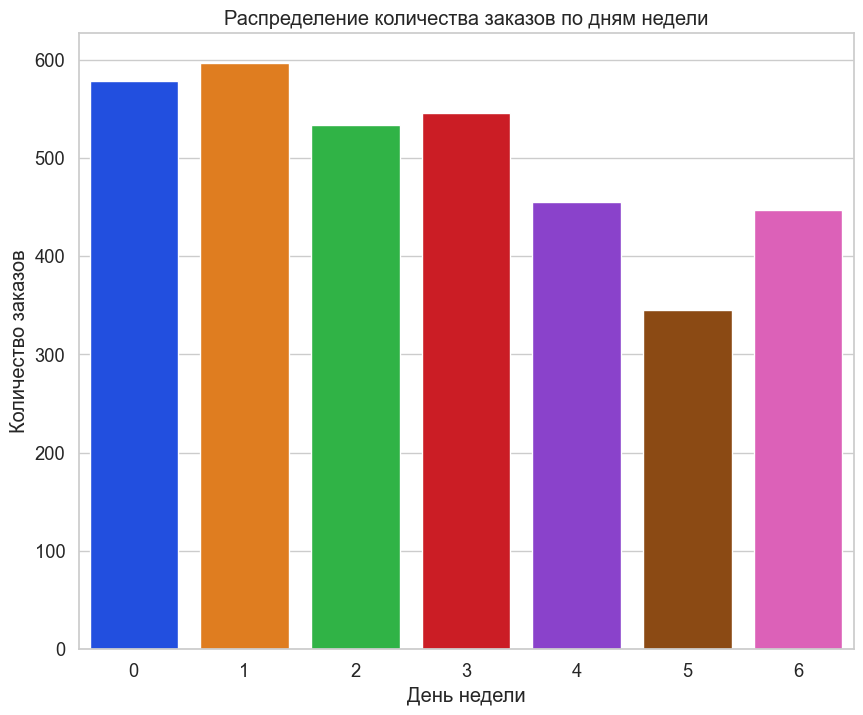

In [15]:
x = df.groupby('weekday')['order_id'].nunique().index
y = df.groupby('weekday')['order_id'].nunique().values

plt.figure(figsize=(10,8))
ax = sns.barplot(x=x, y=y)
ax.set(title = 'Распределение количества заказов по дням недели', 
       xlabel='День недели', 
       ylabel='Количество заказов')
plt.show()

Чаще всего заказывают в начале недели, реже всего - в субботу.

### Сколько заказов в среднем совершает один покупатель?

In [16]:
print(bold_text('Среднее количество заказов на одного покупателя:'),
      round(df['order_id'].nunique() / df['customer_id'].nunique())
     )

Среднее количество заказов на одного покупателя: 1


Судя по всему, пользователи совершают лишь один заказ, после чего больше не возвращаются на сайт.

### Поиск аномалий в данных

In [17]:
df[['quantity', 'price']].describe()

,quantity,price
count,5522.000000,5522.000000
mean,2.577508,531.584224
std,16.506591,975.262577
min,1.000000,9.000000
25%,1.000000,90.000000
50%,1.000000,150.000000
75%,1.000000,524.000000
max,1000.000000,14917.000000


In [18]:
#изучим заказ на 1000 предментов
df[df['quantity'] == 1000]

,date,customer_id,order_id,product,quantity,price,year,month,weekday,total
3819,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,2019,6,1,675000.0


Заказ на 1000 вантузов суммой в 675000. Вероятно, это была оптовая закупка для какого-то предприятия. Избавимся от этой строки, чтобы не искажать результаты

In [19]:
df = df.query('customer_id != "312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6"')

In [20]:
df=df.reset_index(drop=True)

In [21]:
df.groupby(pd.Grouper(key="date", freq="D"))['order_id'].nunique().sort_values(ascending=False)

date
2020-01-16    24
2020-01-22    21
2019-11-22    19
2019-10-16    18
2020-01-04    18
              ..
2018-12-31     0
2019-06-29     0
2018-12-30     0
2019-01-08     0
2019-06-22     0
Name: order_id, Length: 488, dtype: int64

### Выручка 

In [22]:
revenue = pd.pivot_table(df,
                         index=['year', 'month'],
                         values=['total'], aggfunc='sum')
revenue

total
year month           
2018 10     351162.00
     11     359348.00
     12     345921.00
2019 1      230097.00
     2      305183.00
     3      249429.00
     4      316469.00
     5      233874.00
     6      225116.00
     7      234932.00
     8      172100.00
     9      177951.00
     10     207441.00
     11     128791.75
     12     202885.33
2020 1      174036.33

In [23]:
revenue = revenue.reset_index()

Text(59.072785714285715, 0.5, 'Выручка')

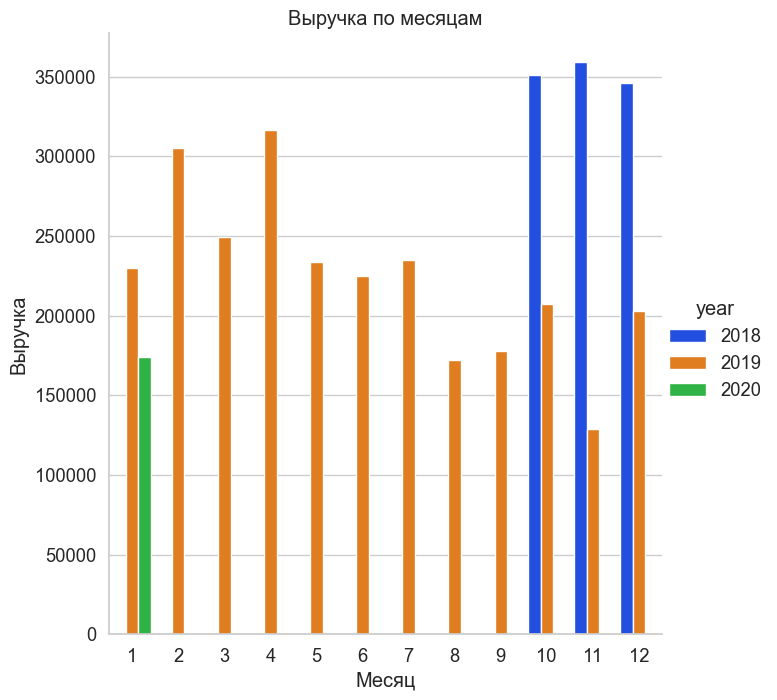

In [24]:
sns.catplot(data=revenue,
            kind='bar',
            x='month',
            y='total',
            hue='year',
            height=7
           )  
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')

Наибольшая выручка была в октябре - декабре 2018 года, в этот период она держалась на уровне 350000 тысяч в месяц. После этого она лишь дважды переваливала за 300000 (в феврале и апреле 2019 года).

### Средний чек

In [25]:
average_check = pd.pivot_table(df,
                               index=['year', 'month'],
                               values=['total', 'order_id'], 
                           aggfunc={'total': 'sum', 'order_id': 'nunique'})

average_check['avg_check'] = average_check['total']/average_check['order_id']
average_check

order_id      total    avg_check
year month                                  
2018 10          238  351162.00  1475.470588
     11          204  359348.00  1761.509804
     12          278  345921.00  1244.320144
2019 1           165  230097.00  1394.527273
     2           286  305183.00  1067.073427
     3           242  249429.00  1030.698347
     4           264  316469.00  1198.746212
     5           178  233874.00  1313.898876
     6           156  225116.00  1443.051282
     7           198  234932.00  1186.525253
     8           172  172100.00  1000.581395
     9           179  177951.00   994.139665
     10          201  207441.00  1032.044776
     11          217  128791.75   593.510369
     12          246  202885.33   824.737114
2020 1           269  174036.33   646.975204

Text(55.939214285714286, 0.5, 'Средний чек')

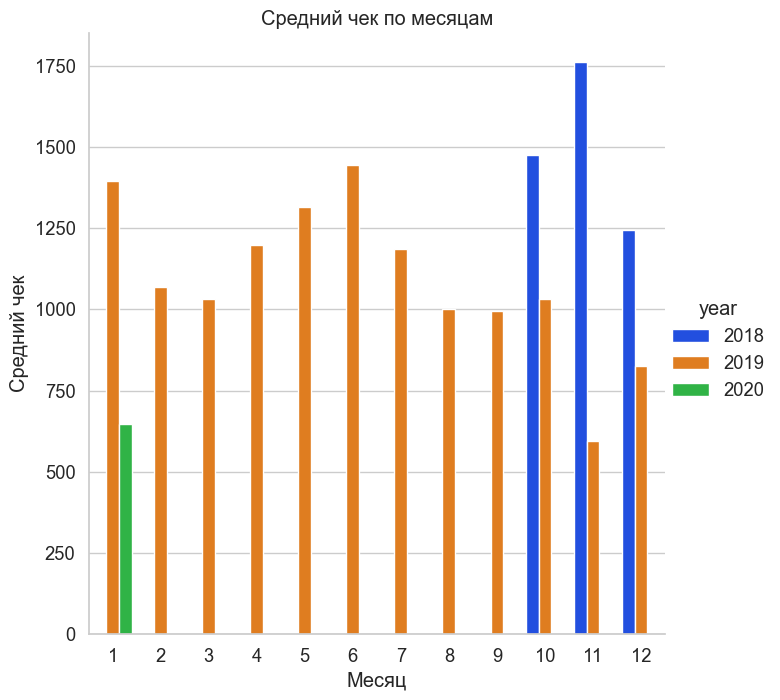

In [26]:
average_check = average_check.reset_index()
sns.catplot(data=average_check,
            kind='bar',
            x='month',
            y='avg_check',
            hue='year',
            height=7
)  
plt.title('Средний чек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')

Весной и ранним летом заметна тенденция к повышению  среднего чека. Максимальный же средний чек (размером в 1760₽) наблюдался в ноябре 2018. Минимальный средний чек (590₽) был тоже в ноябре, но уже 2019 года. 

### Выручка с покупателя

In [27]:
average_revenue = pd.pivot_table(df,
                                 index=['year', 'month'],
                                 values=['total', 'customer_id'], 
                             aggfunc={'total': 'sum', 'customer_id': 'nunique'})

average_revenue['avg_revenue'] = average_revenue['total']/average_revenue['customer_id']
average_revenue

customer_id      total  avg_revenue
year month                                     
2018 10             179  351162.00  1961.798883
     11             178  359348.00  2018.808989
     12             228  345921.00  1517.197368
2019 1              149  230097.00  1544.275168
     2              244  305183.00  1250.750000
     3              227  249429.00  1098.806167
     4              235  316469.00  1346.676596
     5              164  233874.00  1426.060976
     6              147  225116.00  1531.401361
     7              186  234932.00  1263.075269
     8              164  172100.00  1049.390244
     9              171  177951.00  1040.649123
     10             172  207441.00  1206.052326
     11             217  128791.75   593.510369
     12             246  202885.33   824.737114
2020 1              269  174036.33   646.975204

Text(55.939214285714286, 0.5, 'Средняя выручка')

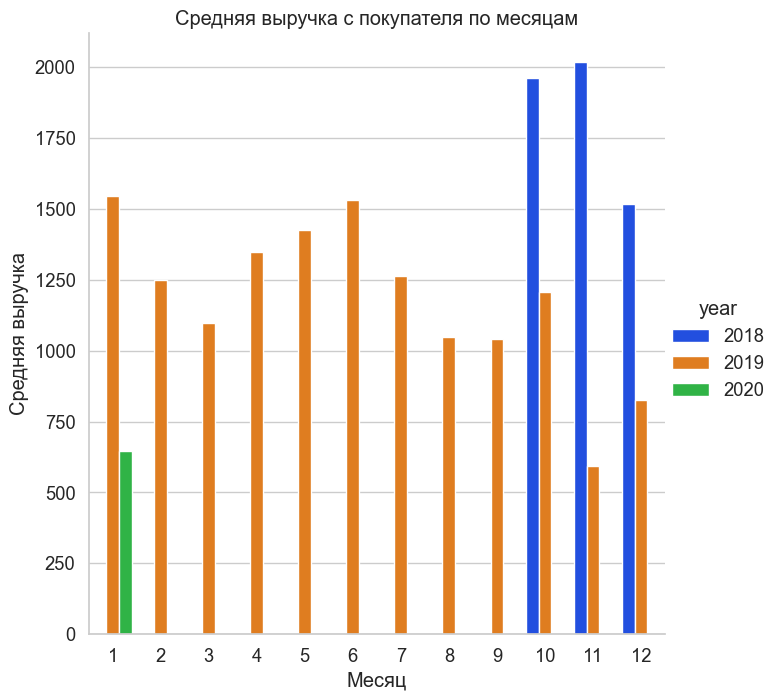

In [28]:
average_revenue = average_revenue.reset_index()
sns.catplot(data=average_revenue,
            kind='bar',
            x='month',
            y='avg_revenue',
            hue='year',
            height=7
)  
plt.title('Средняя выручка с покупателя по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка')

Наибольшая средняя выручка с покупателя наблюдалась в октябре (1940₽) и ноябре (2020₽) 2018 года. 

### Ассортимент магазина, выделение основных товарных категорий

In [29]:
print(bold_text('Количество уникальных наименований:'), df['product'].nunique())

Количество уникальных наименований: 2331


В наших данных присутсвует 2331 уникальное наименование товара. Попробуем разбить все товары на категории. Перед этим для удобства приведем названия товаров к их словарным формам.

In [30]:
m = Mystem()

lemmas = []
for i in df['product'].unique():
    lemmas = ' '.join(m.lemmatize(i))
    lemmas = lemmas.split()
    print(lemmas)

['комнатный', 'растение', 'в', 'горшок', 'алый', 'вера', ',', 'd12', ',', 'h30']
['комнатный', 'растение', 'в', 'горшок', 'кофе', 'арабика', ',', 'd12', ',', 'h25']
['радермахер', 'd', '-', '12', 'см', 'h', '-', '20', 'см']
['хризолидокарпус', 'лутесценс', 'd', '-', '9', 'см']
['циперус', 'зумул', 'd', '-', '12', 'см', 'h', '-', '25', 'см']
['шеффлер', 'лузеан', 'd', '-', '9', 'см']
['юкка', 'нитчатый', 'd', '-', '12', 'см', 'h', '-', '25', '-', '35', 'см']
['настенный', 'сушилка', 'для', 'белье', 'gimi', 'brio', 'super', '100']
['таз', 'пластмассовый', '21', ',', '0', 'л', 'круглый', '"', 'водолей', '"', 'с614', ',', '1404056']
['чехол', 'для', 'гладильный', 'доска', 'colombo', 'persia', 'beige', '130х50', 'см', 'из', 'хлопок', '5379']
['вешалка', 'для', 'брюки', 'металлический', 'с', 'резиновый', 'покрытие', '26', 'см', 'цвет', ':', 'синий', ',', 'attribute', ',', 'ahs331']
['сушилка', 'для', 'белье', 'потолочный', 'zalger', 'lift', 'basic', '1520', '200', 'см', ',', '10', 'м']
['чех

Разделим товары на следующие категории: 

In [31]:
plants = ['комнатный', 'растение', 'цветущий', 'горшок', 'радермахер','хризолидокарпус',
          'лутесценс', 'циперус', 'шеффлер', 'юкка', 'многолетний', 'рассада',
          'зелень', 'базилик', 'кассета', 'мелисса', 'герань', 'цвести',
          'пеларгония', 'котел', 'суккулент', 'эхеверие', 'эвкалипт', 'адиантум',
          'калатея', 'нолина', 'хлорофитум', 'цикламен', 'глоксиния',  'азалия', 'гортензия',
        'хризантема', 'мирт', 'кориандр', 'иссоп', 'сантолина', 'аспарагус',
        'афеляндра', 'антуриум', 'молодило', 'фиалка', 'гербера',
        'душица', 'роза', 'бегония', 'розмарин', 'альбук','крассула',
        'артемизия', 'пуансеттия', 'дерево', 'скиммия', 'фиттоний', 'тимьян', 'алоэ',
          'аптение', 'спатифиллум', 'фикус', 'азалия', 'кодонант', 'фаленопсис', 'гимнокалициум',
          'примула', 'кофе', 'эхинокактус', 'вантуз', 'бальзамин', 'эхеверие', 'крокус', 'гипсофил', 'дендробиум',
          'калибрахоа', 'эпипремнум', 'горох', 'земляника', 'незабудка', 'седум', 'томат', 'укроп', 
          'нефролепис', 'калла', 'декабрист', 'тюльпан', 'однолетний', 'чабер', 'бакоп', 'ранункулус', 
          'плантация', 'овсянница', 'георгин', 'календула', 'косметь', 'смолевка', 'цинния', 'лавр', 
          'мята', 'вербейник', 'виола', 'травянка', 'колокольчик', 'котовник', 'флокс', 'эхинацея', 
          'ясколка', 'калибрахоа', 'петуния', 'лилейник', 'папоротник', 'платикодон', 'энотера', 'садовый',
          'фуксия', 'цитрофортунелла', 'пеперомия', 'дыня', 'гардения', 'раннеспелый', 'скороспелый', 'среднеспелый',
          'лобелия', 'настурция', 'виноград', 'детерминантный', 'индетерминантный', 'пиретрум',
          'кашпо', 'муррайя', 'вероника', 'крым', 'фатсия', 'хоста', 'гайлардий', 'травянистый', 'барвинок', 
          'осина', 'черенок', 'аквилегия', 'бузульник', 'камнеломка', 'солидаго', 'физостегия', 'бадан', 'лен',
          'лантан', 'лаватер', 'анемон', 'крупноплодный', 'хамедорей', 'мединилла', 'микс', 'бальзамин', 'диффенбахий',
          'рукол', 'пахира', 'эхинокактус', 'каланхое', 'двухцветный', 'лаванда', 
         'трехцветный', 'капсикум', 'мимоза', 'соланум', 'полянка', '4660010775921', '4660010776102',
          'алиссум', 'гвоздик', 'годеция', 'смесь', 'кореопсис', 'лапчатка', 'цинерария',
          'эшшольция', 'подсолнечник', 'вербена', 'позднеспелый', 'джункус', 'драцена', 'волгоградец', 
          'гибридный', 'крупноцветковый', 'рудбекия', 'зверобой', 'замиокулькас', 'петрушка', 
          ]

home = ['сушилка', 'таз', 'гладильный', 'сумка', 'тележка', 'муляж', 'настенный',
         'прищепок','напольный', 'искусственный', 'мусорный', 'мусор',
         'крючок','стремянка', 'стяжка', 'крепеж', 'пружина', 'петля',
        'светильник', 'подрукавник', 'карниз', 'ведро',
      'корыто', 'сварка', 'сверло', 'свереть', 'шнур', 'урна', 'угольник', 'линейка', 
        'обувной', 'пробка', 'весы', 'инструмент', 'фоторамка', 'корыто ', 'фал', 
        'штангенциркуль', 'напильник', 'бак', 'пепельница', 'фиксатор', 'валик', 'шпагат', 
        'бидон', 'ваза', 'завертка', 'мебельный', 'шпингалет', 'ролик', 'термометр', 'ковш',
        'сетка', 'искуственный', 'пуф', 'подставка', 'решетка', 'уголок', 'подарочный', 'бензин', 'ручка', '']

kitchen = ['сковорода', 'крышка', 'тарелка', 'обеденный', 'вилка', 'столовая', 
           'чайная', 'нож', 'столовый', 'кружка', 'фужер', 'кувшин', 
           'толкушка', 'банка', 'противень', 'салфетка', 'tepмокружка', 'термокружок', 'ножеточка', 
           'масленка', 'салатник', 'чайный', 'овощеварка', 'посуда', 'фужер',
           'терка', 'приготовление', 'лопатка', 'салфетница', 'стакан', 'овощечистка', 
           'термос', 'разделочный', 'чайный', 'бокал', 'бульонница', 'пароварка', 'емкость', 
           'термостакан', 'просеиватель', 'кастрюля', 'хлебница', 'выпечка', 'орехоколка', 'скалка', 
           'венчик', 'сито','миска', 'выпечка', 'тортница', 'блюдо', 'лоток', 'кухонный', 'сотейник', 'кондитерский',
           'сахарница', 'соковарка', 'пьезозажигалка', 'половник', 'яйцо', 'рыбочистка', 'губка', 
           'мантоварка', 'картофелемялка', 'плита', 'кекс', 'пресс', 'дуршлаг', 'блюдце',
           'контейнер', 'соль', 'продукт', 'отделитель', 'соковыжималка'
           ]

bathroom = ['ванна', 'ванный', 'сидение', 'мыльница', 'штанга', 'ерш', 'дозатор', 'мыло',
             'зубной',  'паста', 'подголовник', 'туалетной', 'маска', 'туалетный']

appliances = ['миксер',  'чайник', 'утюг', 'фен', 'электроштопор', 'миксер', 'пылесос', 'электронный', 'кипятильник']

cleaning = ['щетка', 'перчатка', 'стиральный', 'чистить', 
           'веник', 'швабра', 'сметка', 'средство', 'кондиционер', 'гель', 'совок', 'mop',
            'концентрат', 'антизасор', 'окномойка', 'моп', 'скребок', 'антинакипин', 'отбеливатель',
            'антижир', 'ополаскиватель', 'тряпкодержатель', 'мытье', 'тряпка', 'стирка'
           ]

storage =['вешалка', 'корзина', 'плечики', 'кофр', 'ящик', 'короб', 
          'коробка', 'этажерка', 'комод', 'ключница', 'полка', 'обувница', 'полк', 'хранение',
          'подставка', 'стеллаж']

textile = ['чехол', 'подкладка', 'плед', 'скатерть', 'коврик', 'ковер', 
           'простыня', 'штора', 'подушка', 'полотенце', 'наматрасник', 'наматрицник', 'наматрацник',
           'халат', 'полк', 'ткань', 'одеяло', 'наволочка', 'пододеяльник', 'покрывало', 'белье',
           ]


In [32]:
def lemmas_category(name):
    lemmas = ' '.join(m.lemmatize(name))
    lemmas = lemmas.split()
    for i in lemmas:
        if i in plants:
            return 'Сад и огород'
        if i in home:
            return 'Товары для дома и ремонта'
        if i in kitchen:
            return 'Товары для кухни'
        if i in appliances:
            return 'Бытовая техника'
        if i in cleaning:
            return 'Товары для уборки и гигиены'
        if i in storage:
            return 'Хранение' 
        if i in textile:
            return 'Текстиль'
        if i in bathroom:
            return 'Товары для ванной комнаты'              
    return 'Другое'

for i in range(len(df['product'])):
    df.loc[i, 'category'] = lemmas_category(df.loc[i, 'product'])

### Какова доля каждой категории?

In [33]:
category_counts = df.groupby('category')['product'].count().sort_values(ascending=False)
category_counts

category
Сад и огород                   2763
Товары для дома и ремонта      1474
Текстиль                        440
Товары для кухни                419
Хранение                        197
Товары для уборки и гигиены     121
Товары для ванной комнаты        72
Бытовая техника                  35
Name: product, dtype: int64

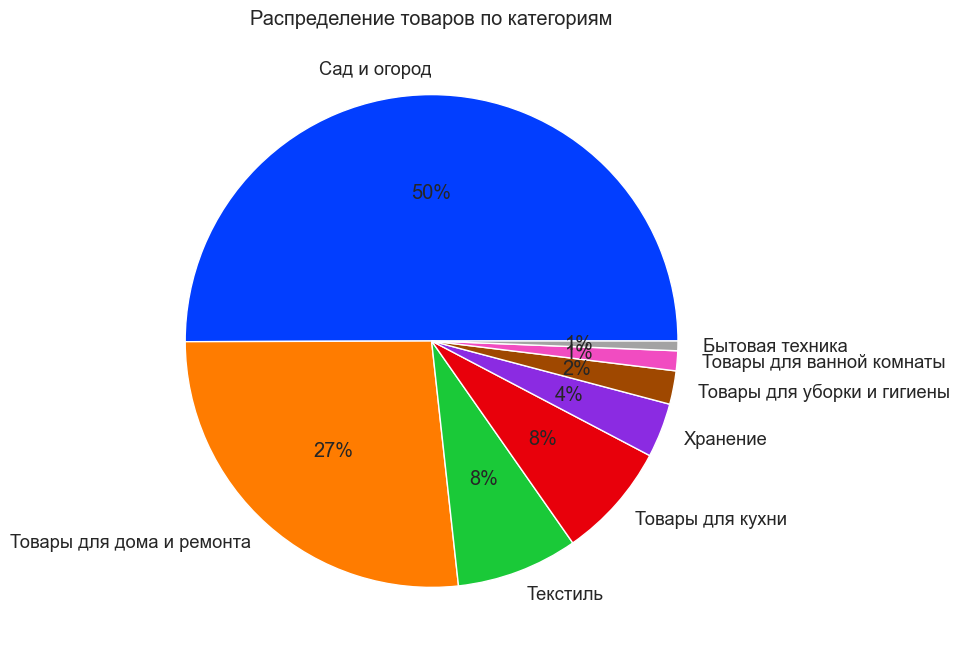

In [34]:
plt.figure(figsize=(8,8))
plt.pie(category_counts, labels=category_counts.index, autopct='%.0f%%')
plt.title('Распределение товаров по категориям')
plt.show()

**Мы выделили 8 товарных категорий, вот как распределено количество проданного товара в них:**  
+ Сад и огород - 50% от всех товаров на сайте  
+ Товары для дома и ремонта - 27%  
+ Товары для кухни - 8%   
+ Текстиль - 8%  
+ Хранение - 4%  
+ Товары для уборки и гигиены - 2%  
+ Товары для ванной комнаты - 1%  
+ Бытовая техника - 1%  

### Продажи категорий по месяцам

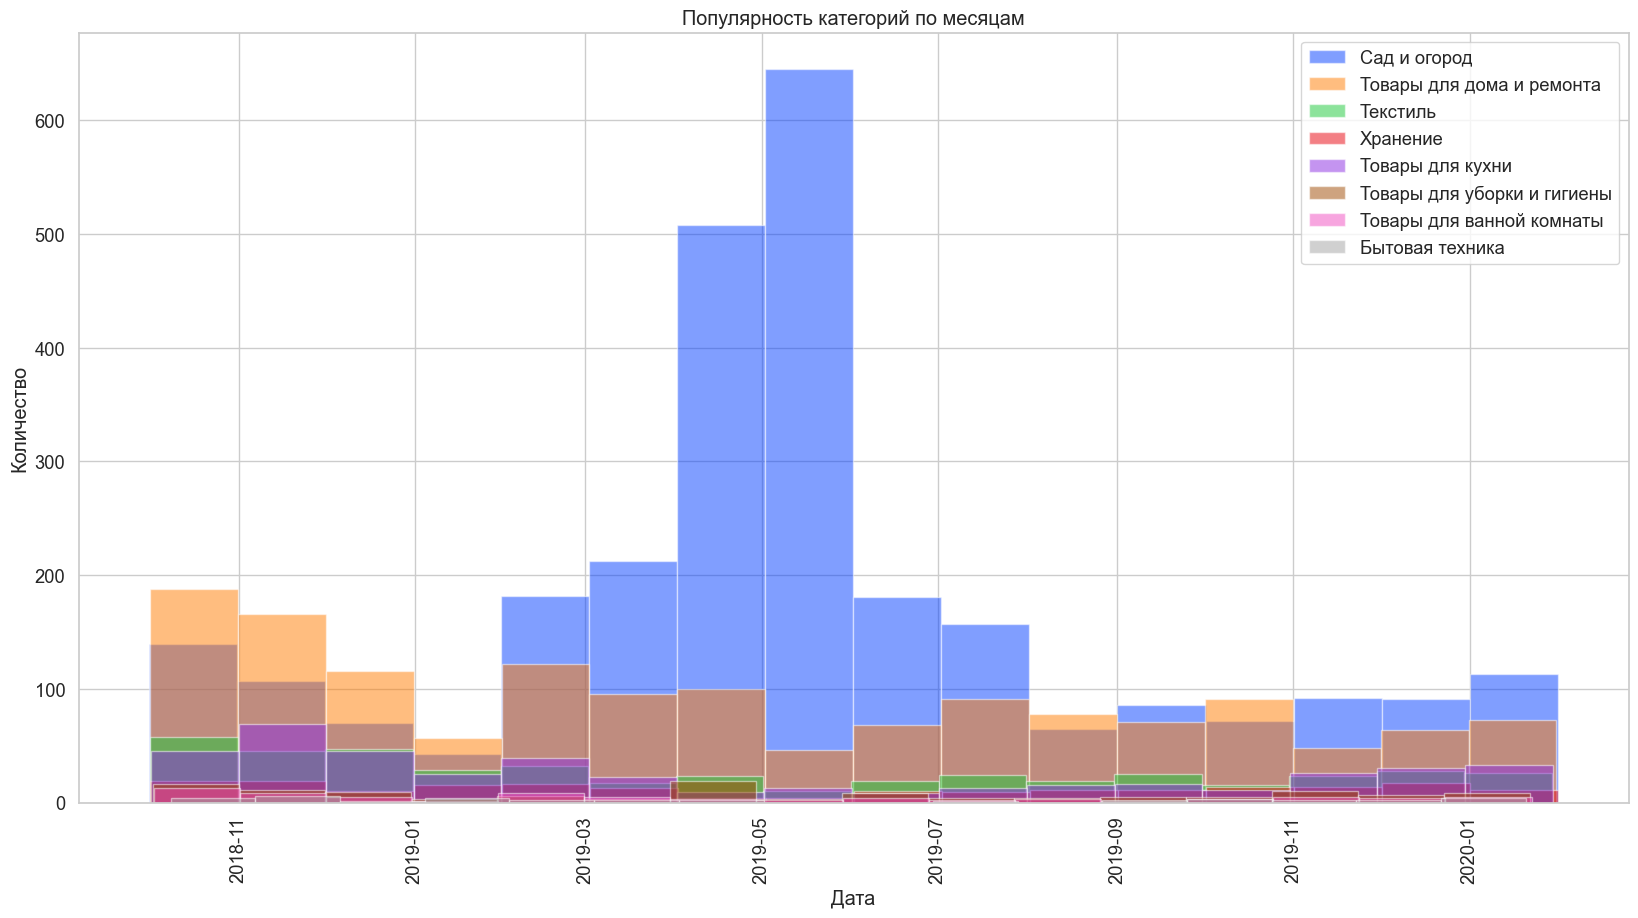

In [35]:
plt.figure(figsize=(20, 10))

for i in df['category'].unique():
    t=df.query('category==@i')
    t['date'].hist(bins=16, alpha=0.5, label=i)

plt.title('Популярность категорий по месяцам')
plt.xlabel('Дата')  
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.legend()
plt.show()

***
**В ходе исследовательского анализа было выявлено:**  
+ Мы располагаем данными за 1 год и 4 месяца (с 2018-10-01 по 2020-01-31);    
+ За это время 2451 покупателей совершило 3521 заказов;  
+ Пользователи совершают лишь один заказ, после чего больше не возвращаются на сайт.
+ Чаще всего заказы оформляются в начале недели, реже всего - в субботу;    
+ Весной и ранним летом заметна тенденция к повышению  среднего чека;  
+ Выручка, средний чек и средняя выручка с покупателя снизились в 2019 и 2020 году. Возможно, в 2018 году были акции и рекламные кампании, которые привлекли большое количество клиентов и тем самым повысили продажи, однако в дальнейшем все показатели снизились;  
+ Проведена категоризация товаров, после которой выделилось 8 товарных категорий. Вот как распределено количество проданного товара в них:  
  + Сад и огород - 50% от всех товаров на сайте  
  + Товары для дома и ремонта - 27%  
  + Товары для кухни - 8%   
  + Текстиль - 8%  
  + Хранение - 4%  
  + Товары для уборки и гигиены - 2%  
  + Товары для ванной комнаты - 1%  
  + Бытовая техника - 1%.
+ Наиболее популярной категорией является "Сад и огород", товары из неё приобретаются в 50% заказов, причем больше всего заказов приходится на апрель и май. На втором месте по популярности расположилась категория «Товары для дома и ремонта» - содержится в 27% заказов, конкретную сезонность выделить сложно, но количество заказов в этой категории всё же несколько возрастает в период с октября по декабрь, возможно в предверии праздников.  

## Сегментация покупателей на основе истории их покупок

### Кластеры покупателей

In [36]:
#подготовим необходимые данные
data = (df.groupby('customer_id')
        .agg({'order_id': 'nunique',
              'price': ['sum', 'mean'],
              'quantity': 'sum',
              #'product': 'nunique',
              'category': 'nunique'})
        .reset_index()
       )
data.columns = data.columns.droplevel(1)
data.columns = (['customer_id',
                'order_count',
                'revenue_by_customer',
                'avg_check',
                'item_count',
                #'item_name_count',
                'category_count'])
data.sample(5)

,customer_id,order_count,revenue_by_customer,avg_check,item_count,category_count
1355,923c1f96-6a15-48aa-ab64-6a92fb2440c0,1,187.0,187.0,1,1
1924,cda6de4f-2d47-40ec-8d46-c5221348fbc5,1,1612.0,1612.0,1,1
2055,dae77d02-6c91-448a-bd8f-ce2b47b3c8ea,1,374.0,374.0,1,1
2332,f71a41ab-df06-4c9f-a4bf-474e368a40d2,1,45.0,45.0,3,1
522,370ed405-57f6-4eff-ab2e-a0bacab6e982,2,231.0,115.5,2,2


Подготовили сводную таблицу, содержащию в себе информацию о каждом покупателе. Перед тем, как перейти к кластеризации, проверим таблицу на наличие выбросов.

In [37]:
data[['order_count', 'revenue_by_customer']].describe()

,order_count,revenue_by_customer
count,2412.000000,2412.000000
mean,1.447347,1216.721842
std,2.698627,3176.993960
min,1.000000,14.000000
25%,1.000000,217.000000
50%,1.000000,638.000000
75%,2.000000,1477.000000
max,126.000000,133397.000000


In [38]:
data[data['revenue_by_customer'] > 100000]

,customer_id,order_count,revenue_by_customer,avg_check,item_count,category_count
1884,c971fb21-d54c-4134-938f-16b62ee86d3b,126,133397.0,932.846154,334,8


Удалим из таблицы пользователя, совершившего 126 заказов на сумму 133397, чтобы он не помешал корректной кластеризации, иначе он единственный попадёт в отдельный кластер.

In [39]:
data = data.query('customer_id != "c971fb21-d54c-4134-938f-16b62ee86d3b"')

In [40]:
#выбор признаков для кластеризации
X = data.drop(['customer_id'], axis=1)
X

,order_count,revenue_by_customer,avg_check,item_count,category_count
0,1,555.0,138.75,4,1
1,1,442.0,442.00,1,1
2,1,457.0,457.00,2,1
3,1,1649.0,1649.00,1,1
4,1,1162.0,1162.00,2,1
...,...,...,...,...,...
2407,2,1739.0,869.50,2,2
2408,1,397.0,397.00,1,1
2409,1,389.0,389.00,1,1
2410,1,974.0,974.00,1,1


In [41]:
#стандартизация данных перед работой с алгоритмами 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

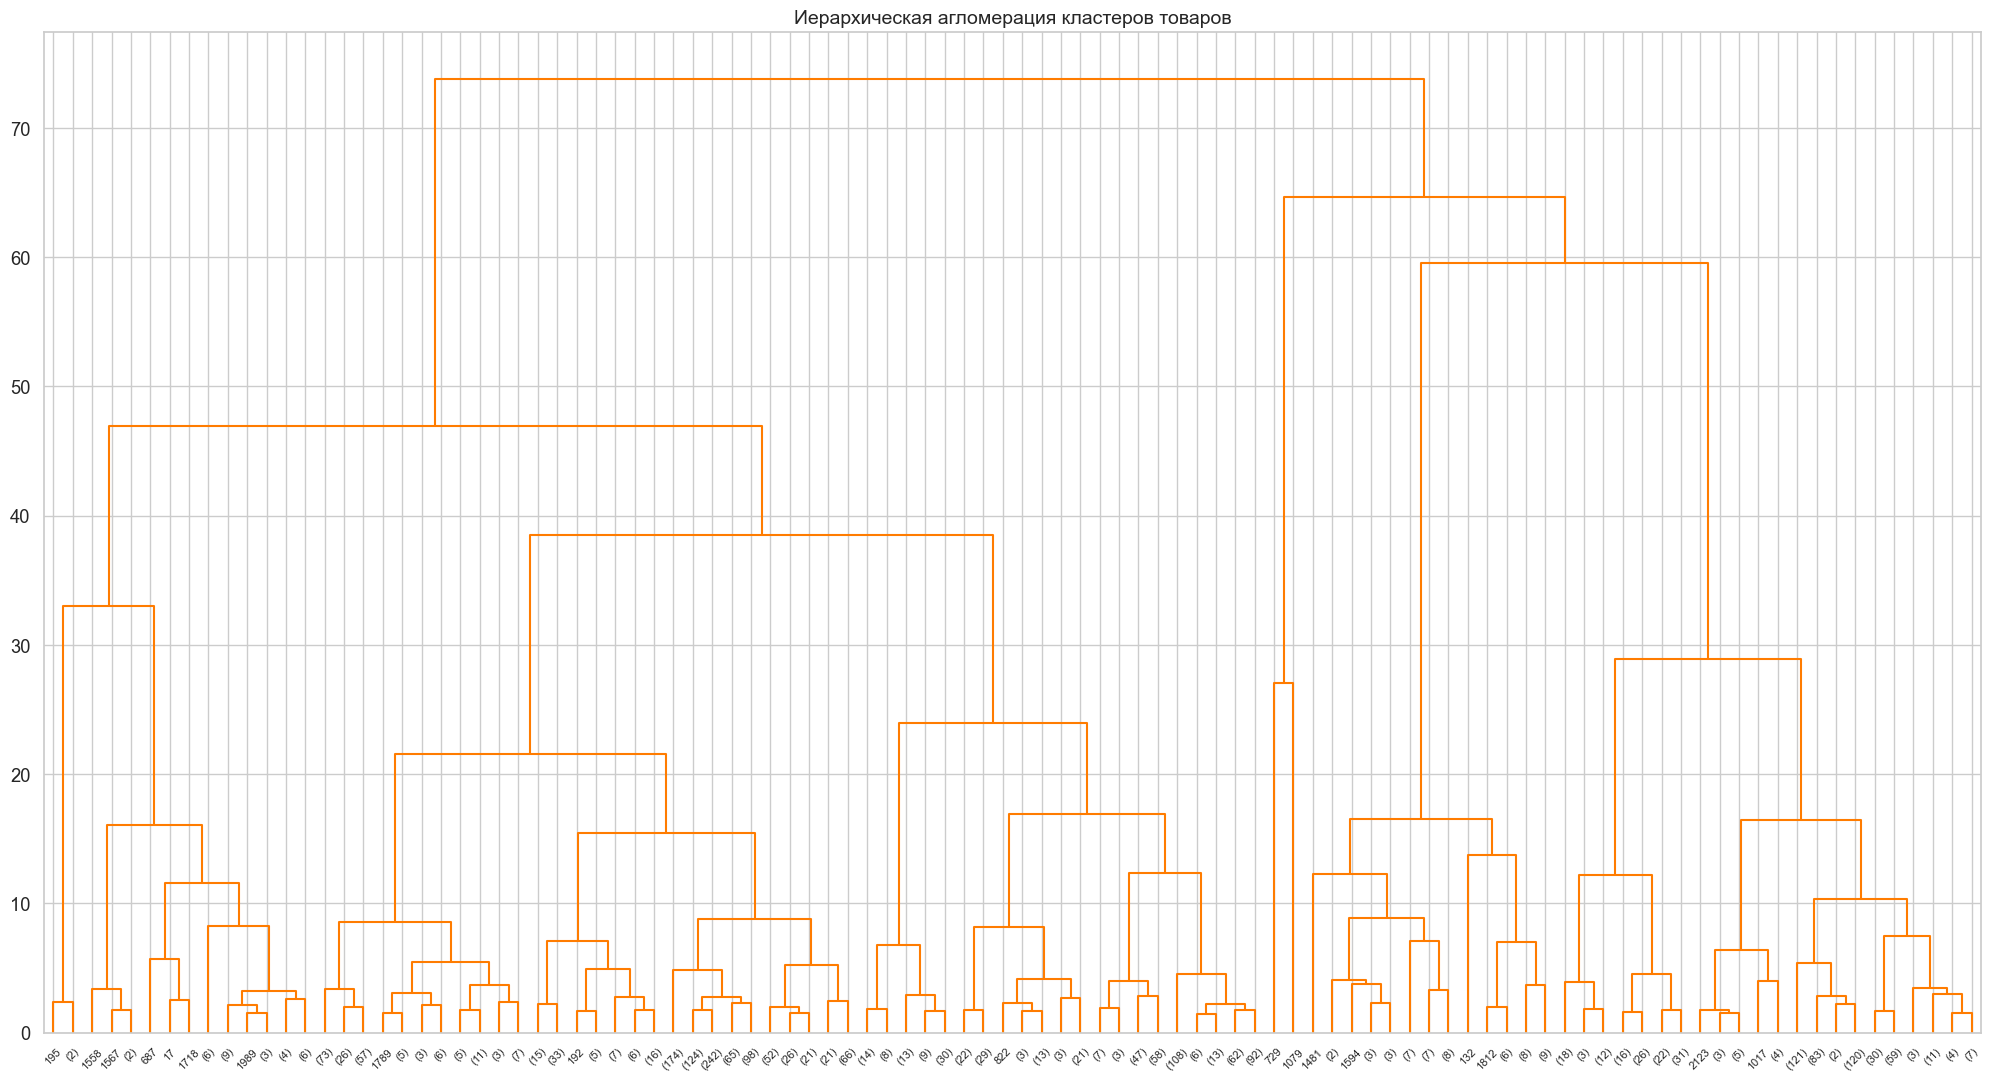

In [43]:
#определим оптимальное число кластеров
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(25, 13))
plt.title('Иерархическая агломерация кластеров товаров', fontsize=14)
dendrogram(linked, orientation='top', leaf_rotation=45., leaf_font_size = 8., truncate_mode='lastp', p=100, color_threshold=80)
plt.show()

Примем 3 за оптимальное число кластеров.

In [44]:
#задаем число кластеров и применяем алгоритм к данным
n = 3
km = KMeans(n_clusters = n, random_state=0) 
labels = km.fit_predict(X_sc) 
#сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

C:\Users\sdibi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
#проверим количество пользователей в кластерах
data['cluster_km'].value_counts()

1    1682
0     552
2     177
Name: cluster_km, dtype: int64

In [46]:
#средние значения признаков в каждом кластере
clusters = data.groupby('cluster_km').mean().round(0).T
clusters

C:\Users\sdibi\AppData\Local\Temp\ipykernel_18976\2606753844.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clusters = data.groupby('cluster_km').mean().round(0).T


cluster_km,0,1,2
order_count,2.0,1.0,2.0
revenue_by_customer,1346.0,657.0,5380.0
avg_check,641.0,444.0,3521.0
item_count,3.0,6.0,4.0
category_count,2.0,1.0,1.0


**Вывод:**  
Сегментировали пользователей на 3 подгруппы по следующим признакам: количество заказов, выручка с покупателя, средний чек, количество товаров, количество наименований, количество категорий. 
+ В кластер "0" вошло 1682 покупателя, совершающих в среднем 2 заказа и приносящих магазину в среднем 1350₽ при среднем чеке в 640₽ 
+ В кластер "1" вошло 552 покупателя, совершающих в среднем 1 заказ и приносящих магазину в среднем 660₽ при среднем чеке в 440₽ 
+ В кластер "2" попало 177 покупателей, он отличается максимальной средней выручкой с покупателя (5380₽) и средним чеком в 3520₽   

### Количество товаров по категориям в кластерах

In [47]:
#создадим объединенный датафрейм
segment = df.merge(data, on='customer_id')
segment.sample(5)

,date,customer_id,order_id,product,quantity,price,year,month,weekday,total,category,order_count,revenue_by_customer,avg_check,item_count,category_count,cluster_km
1301,2019-01-05 04:00:00,6ab10937-fd06-4010-9178-6b5bcc7cdc1d,69706,вешалка гардеробная радуга 1 зми белое серебро...,1,824.0,2019,1,5,824.0,Хранение,1,824.0,824.000000,1,1,1
1498,2019-01-28 22:00:00,6c5b3e2b-719c-4af2-829c-98fe706a6fb8,70010,чехол eurogold clean metallic металлизированый...,1,299.0,2019,1,0,299.0,Текстиль,2,418.5,209.250000,2,2,0
2496,2019-04-02 12:00:00,a3394ff2-4cd2-4332-9f6c-2668ac608fbc,14608,калибрахоа aloha double purple сиреневая махро...,1,82.0,2019,4,1,82.0,Сад и огород,2,1808.0,60.266667,30,1,1
3582,2019-05-14 19:00:00,bea7a833-2074-42db-bc49-4457abd3c930,14777,однолетнее растение львиный зев в кассете по 4...,2,82.0,2019,5,1,164.0,Сад и огород,4,1835.0,131.071429,30,1,1
4188,2019-06-20 15:00:00,9e4a2871-47bb-46ef-ba4a-1b2a96fb8513,71760,мята перечная тач tachi d-7 см h-10 см мандари...,1,74.0,2019,6,3,74.0,Сад и огород,1,74.0,74.000000,1,1,1


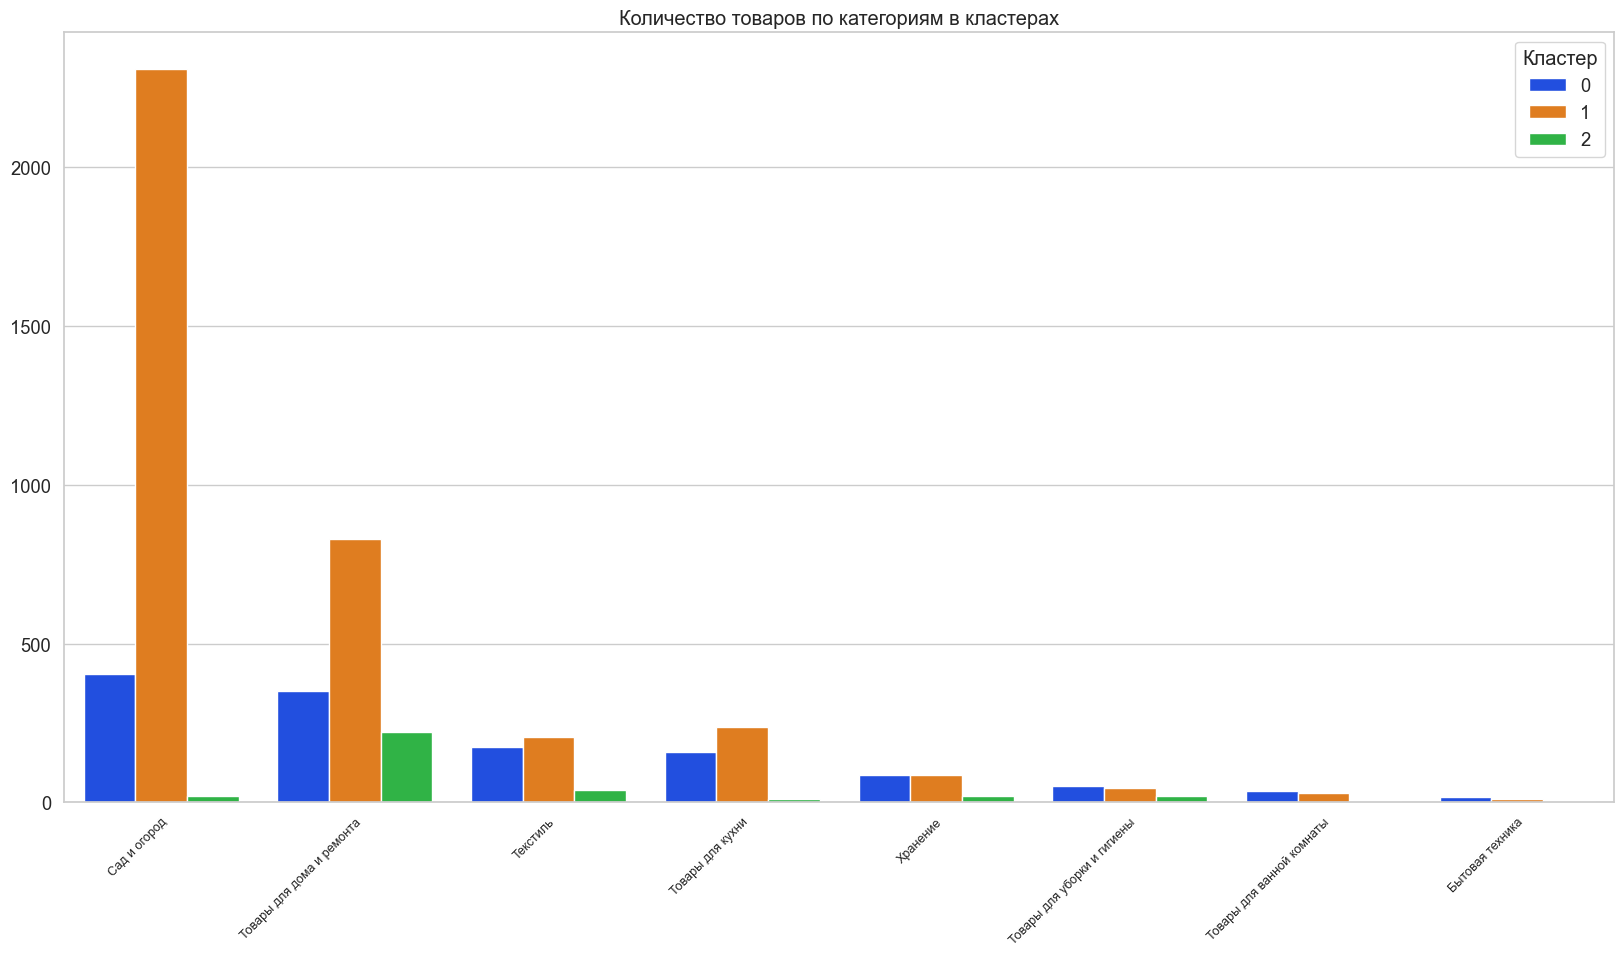

In [48]:
plt.figure(figsize=(20, 10))
sns.countplot(data=segment, x='category', hue='cluster_km',order=segment['category'].value_counts().index)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=9)
plt.title('Количество товаров по категориям в кластерах')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Кластер')
plt.show()

+ Покупатели из кластера "0" покупают товары равномерно из всех категорий, но чуть чаще приобретают из категории "Сад и огород" 
+ Кластер "1" явно отдает предпочтение товарам из категории "Сад и огород" 
+ Кластер "2" в основном приобретает товары из категории "Товары для дома и ремонта"

### Сравнение сезонности категорий товаров у пользовательских сегментов

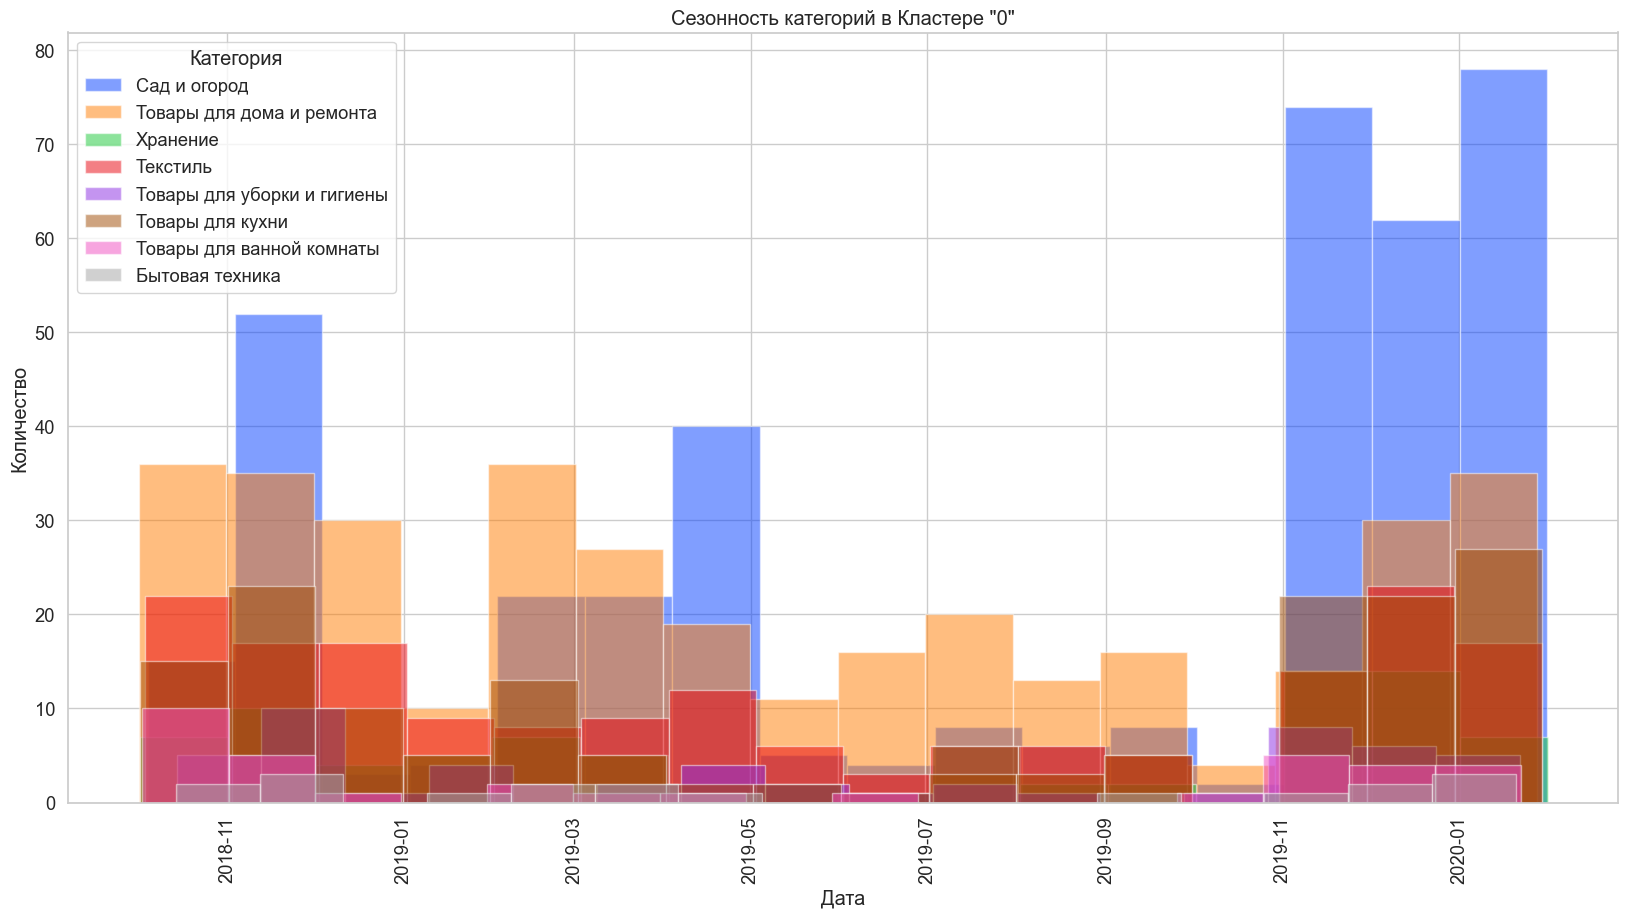

In [49]:
plt.figure(figsize=(20, 10))

for i in segment['category'].unique():
    t=segment.query('category==@i  & cluster_km==0')
    t['date'].hist(bins=16, alpha=0.5, label=i)

plt.title('Сезонность категорий в Кластере "0"')
plt.xlabel('Дата')  
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.legend(title='Категория')
plt.show()

Заметны скачки объема продаж в категории "Сад и огород" в период с декабря по февраль. Интересно, может быть они подготавливают рассаду для высадки весной? Остальные категории не отличаются какой-либо сезонностью и покупаются равномерно в течение всего года.

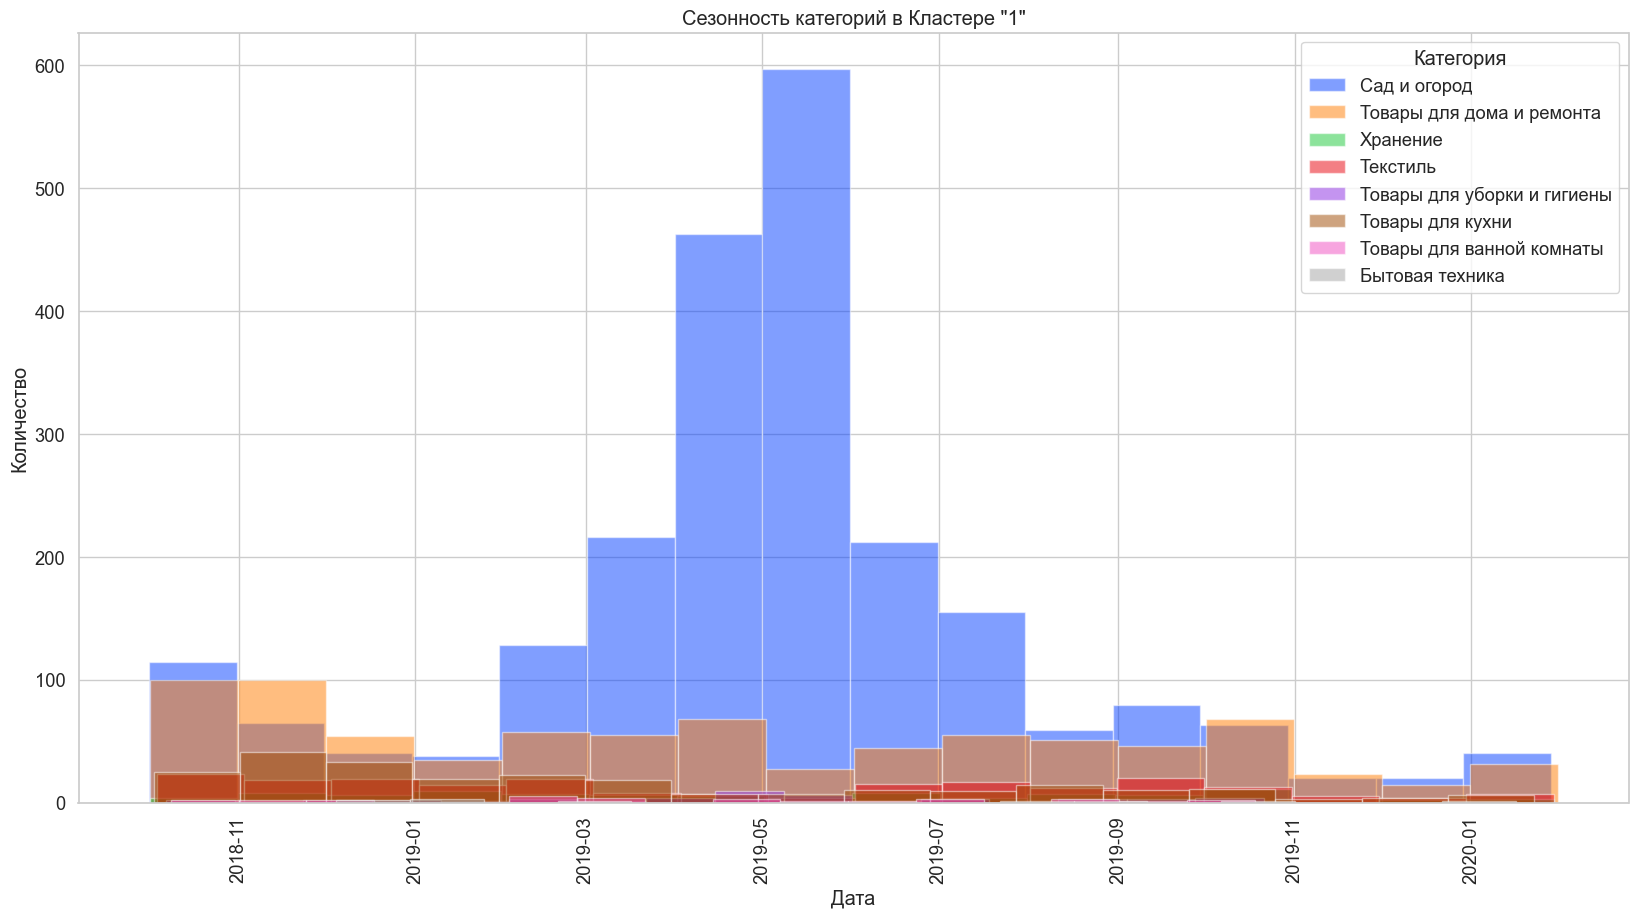

In [50]:
plt.figure(figsize=(20, 10))

for i in segment['category'].unique():
    t=segment.query('category==@i & cluster_km==1')
    t['date'].hist(bins=16, alpha=0.5, label=i)

plt.title('Сезонность категорий в Кластере "1"')
plt.xlabel('Дата')  
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.legend(title='Категория')
plt.show()

В кластер "1" явно попали садоводы-энтузиасты. Популярность товаров из категории "Сад и огород" возрастает с апреля по август с пиком в июне. 

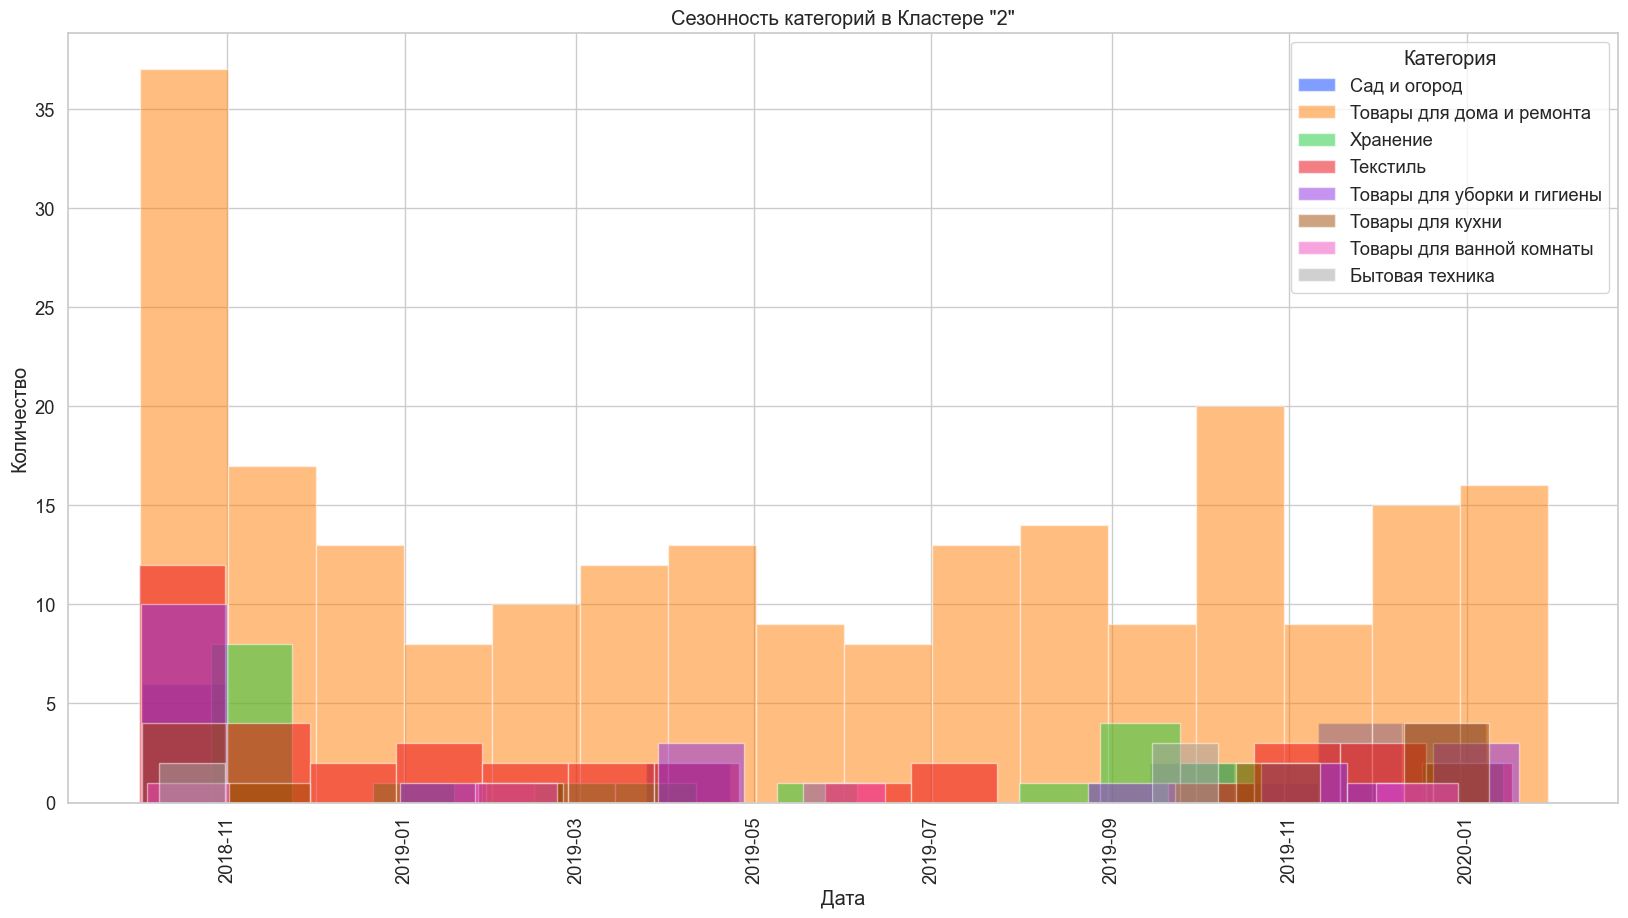

In [51]:
plt.figure(figsize=(20, 10))

for i in segment['category'].unique():
    t=segment.query('category==@i & cluster_km==2')
    t['date'].hist(bins=16, alpha=0.5, label=i)

plt.title('Сезонность категорий в Кластере "2"')
plt.xlabel('Дата')  
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.legend(title='Категория')
plt.show()

В кластере "2" преобладают любители категории "Товары для дома и ремонта". Товары из этой категории приобретаются ими равномерно на протяжении всего года. Так же на графике заметен пик покупок в октябре 2018. Может быть, была какая-то акция на сайте?

**Вывод:**
+ Покупатели из кластера "0" покупают товары равномерно из всех категорий, но чуть чаще приобретают из категории "Сад и огород". Заметны скачки объема продаж в категории "Сад и огород" в период с декабря по февраль. Интересно, может быть они подготавливают рассаду для высадки весной? Остальные категории не отличаются какой-либо сезонностью и покупаются равномерно в течение всего года.  
+ Кластер "1" явно отдает предпочтение товарам из категории "Сад и огород". Популярность товаров из категории "Сад и огород" возрастает с апреля по август с пиком в июне.  
+ Кластер "2" в основном приобретает товары из категории "Товары для дома и ремонта".  Товары из этой категории приобретаются ими равномерно на протяжении всего года. Так же на графике заметен пик покупок в октябре 2018. Может быть, была какая-то акция на сайте?  

## Статистический анализ

### Гипотеза о равенстве выручки между сегментами покупателей
+ *H0* - Нет статистически значимых различий между сегментами покупателей  
+ *H1* - Есть статистически значимые различия между сегментами покупателей 

Выберем уровень статистической значимости в 0.01

In [52]:
#определим переменные для сравнения
cluster0 = data.query('cluster_km==0')['revenue_by_customer']

cluster1 = data.query('cluster_km==1')['revenue_by_customer']

cluster2 = data.query('cluster_km==2')['revenue_by_customer']


Оценим вероятность ошибки первого рода для выбранного уровня значимости:

In [53]:
#вероятность ошибки первого рода для изначального уровня значимости
alpha = 0.01 #критический уровень статистической значимости 
n = 3 #будет произведено 3 сравнения

print(bold_text('Вероятность ошибки первого рода для p-value 0.01 при условии 3 проверок:'), 1-(1-alpha)**n)

if 1-(1-alpha)**n > alpha:
    print('Высокая вероятность ошибки первого рода, нужно сделать поправку на множественные сравнения')
else:
    print('Выбранный уровень значимости оптимален для данного проекта') 

Вероятность ошибки первого рода для p-value 0.01 при условии 3 проверок: 0.029700999999999977
Высокая вероятность ошибки первого рода, нужно сделать поправку на множественные сравнения


Скорректируем уровень значимости, чтобы снизить групповую вероятность ошибки первого рода:

In [54]:
#вероятность ошибки первого рода для скорректированного уровня значимости
alpha_bonferroni = alpha / 3

print(bold_text('Вероятность ошибки первого рода для p-value 0.01 при условии 3 проверок:'), 1-(1-alpha_bonferroni)**n)

if 1-(1-alpha_bonferroni)**n > alpha:
    print('Высокая вероятность ошибки первого рода')
else:
    print('Выбранный уровень значимости оптимален для данного проекта') 

Вероятность ошибки первого рода для p-value 0.01 при условии 3 проверок: 0.009966703703703561
Выбранный уровень значимости оптимален для данного проекта


Проведем тест U-критерий Манна-Уитни

In [55]:
clusters = [cluster0, cluster1, cluster2]
cluster_list = ['cluster0', 'cluster1', 'cluster2']

for index_0 in range(len(clusters)):
    for index_1 in range(index_0+1, len(clusters)):
        p_value = st.mannwhitneyu(clusters[index_0], clusters[index_1], alternative='two-sided')[1]

        print(bold_text('Кластеры'), cluster_list[index_0], cluster_list[index_1])
        print('p_value: {:.3f}'.format(p_value))
        print('Средняя выручка группы A: {:.0f}'.format(clusters[index_0].mean()))
        print('Средняя выручка группы B: {:.0f}'.format(clusters[index_1].mean()))
        
        if p_value < alpha_bonferroni:
            print('\033[31m' + 'Отвергаем нулевую гипотезу: разница статистически значима\n'+ '\033[0m')
        else:
            print('\033[32m' + 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя\n'+ '\033[0m')

Кластеры cluster0 cluster1
p_value: 0.000
Средняя выручка группы A: 1346
Средняя выручка группы B: 657
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры cluster0 cluster2
p_value: 0.000
Средняя выручка группы A: 1346
Средняя выручка группы B: 5380
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры cluster1 cluster2
p_value: 0.000
Средняя выручка группы A: 657
Средняя выручка группы B: 5380
Отвергаем нулевую гипотезу: разница статистически значима



Во всех трёх проверках нам удалось отвергнуть нулевую гипотезу о равенстве выручки между сегментами покупателей

### Гипотеза о равенстве среднего чека между сегментами покупателей
+ *H0* - Нет статистически значимых различий между сегментами покупателей  
+ *H1* - Есть статистически значимые различия между сегментами покупателей 

Выберем уровень статистической значимости в 0.01

In [56]:
#определим переменные для сравнения
cluster0_check = data.query('cluster_km==0')['avg_check']

cluster1_check = data.query('cluster_km==1')['avg_check']

cluster2_check = data.query('cluster_km==2')['avg_check']


Проведем тест U-критерий Манна-Уитни

In [57]:
clusters = [cluster0_check, cluster1_check, cluster2_check]
cluster_list = ['cluster0_check', 'cluster1_check', 'cluster2_check']

for index_0 in range(len(clusters)):
    for index_1 in range(index_0+1, len(clusters)):
        p_value = st.mannwhitneyu(clusters[index_0], clusters[index_1], alternative='two-sided')[1]

        print(bold_text('Кластеры'), cluster_list[index_0], cluster_list[index_1])
        print('p_value: {:.3f}'.format(p_value))
        print('Средняя выручка группы A: {:.0f}'.format(clusters[index_0].mean()))
        print('Средняя выручка группы B: {:.0f}'.format(clusters[index_1].mean()))
        
        if p_value < alpha_bonferroni:
            print('\033[31m' + 'Отвергаем нулевую гипотезу: разница статистически значима\n'+ '\033[0m')
        else:
            print('\033[32m' + 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя\n'+ '\033[0m')

Кластеры cluster0_check cluster1_check
p_value: 0.000
Средняя выручка группы A: 641
Средняя выручка группы B: 444
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры cluster0_check cluster2_check
p_value: 0.000
Средняя выручка группы A: 641
Средняя выручка группы B: 3521
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры cluster1_check cluster2_check
p_value: 0.000
Средняя выручка группы A: 444
Средняя выручка группы B: 3521
Отвергаем нулевую гипотезу: разница статистически значима



Во всех трёх проверках нам удалось отвергнуть нулевую гипотезу о равенстве среднего чека между сегментами покупателей

## Подведение итогов

**Загрузили и изучили** датафрейм, содержащий в себе транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут»  
***
**В ходе предобработки были внесены следующие изменения:**  
+ удалены 1886 дубликата  
+ изменен тип данных в столбце `date`  
+ созданы столбцы `year`, `month` и `weekday` с указанием года, месяца и дня недели  
+ создан столбец `total` с выручкой с каждого заказа  
***
**В ходе исследовательского анализа было выявлено:**  
+ Мы располагаем данными за 1 год и 4 месяца (с 2018-10-01 по 2020-01-31);    
+ За это время 2451 покупателей совершило 3521 заказов;  
+ Большинство пользователей совершает лишь один заказ, после чего больше не возвращается на сайт.
+ Чаще всего заказы оформляются в начале недели, реже всего - в субботу;    
+ Весной и летом заметна тенденция к повышению  среднего чека;  
+ Выручка, средний чек и средняя выручка с покупателя снизились в 2019 и 2020 году. Возможно, в 2018 году были акции и рекламные кампании, которые привлекли большое количество клиентов и тем самым повысили продажи, однако в дальнейшем все показатели снизились;  
+ Проведена категоризация товаров, после которой выделилось 8 товарных категорий. Вот как распределено количество проданного товара в них:  
  + Сад и огород - 50% от всех товаров на сайте  
  + Товары для дома и ремонта - 27%  
  + Товары для кухни - 8%   
  + Текстиль - 8%  
  + Хранение - 4%  
  + Товары для уборки и гигиены - 2%  
  + Товары для ванной комнаты - 1%  
  + Бытовая техника - 1%.
+ Наиболее популярной категорией является "Сад и огород", товары из неё приобретаются в 50% заказов, причем больше всего заказов приходится на апрель и май. На втором месте по популярности расположилась категория «Товары для дома и ремонта» - содержится в 27% заказов, конкретную сезонность выделить сложно, но количество заказов в этой категории всё же несколько возрастает в период с октября по декабрь, возможно в преддверии праздников.  
***
**В результате сегментации покупателей на основе истории их покупок:**  

Сегментировали пользователей на 3 подгруппы по следующим признакам: количество заказов, выручка с покупателя, средний чек, количество товаров, количество категорий.  

+ В кластер "0" вошло 1682 покупателя, совершающих в среднем 2 заказа и приносящих магазину в среднем 1350₽ при среднем чеке в 640₽. Покупатели из данного кластера покупают товары равномерно из всех категорий, но чуть чаще приобретают из категории "Сад и огород". Заметны скачки объема продаж в категории "Сад и огород" в период с декабря по февраль. Интересно, может быть они подготавливают рассаду для высадки весной? Остальные категории не отличаются какой-либо сезонностью и покупаются равномерно в течение всего года.  

+ В кластер "1" вошло 552 покупателя, совершающих в среднем 1 заказ и приносящих магазину в среднем 660₽ при среднем чеке в 440₽. Кластер "1" явно отдает предпочтение товарам из категории "Сад и огород". Популярность товаров из категории "Сад и огород" возрастает с апреля по август с пиком в июне.  

+ В кластер "2" попало 177 покупателей, он отличается максимальной средней выручкой с покупателя (5380₽) и средним чеком в 3520₽. Покупатели из данного кластера в основном приобретает товары из категории "Товары для дома и ремонта".  Товары из этой категории приобретаются ими равномерно на протяжении всего года. Так же на графике заметен пик покупок в октябре 2018. Может быть, была какая-то акция на сайте?  
***
**В ходе статистического анализа:**    

Проверили два набора гипотез: о равенстве выручки между сегментами покупателей и о равенстве среднего чека между сегментами покупателей. 
***

**Рекомендации:**  
+ Акцентировать внимание на предпочтениях пользователей при формировании рекламных рассылок. Пользователям из кластера "0" будут интересны категории "Сад и огород" и "Товары для дома и ремонта", кластер "1" заинтересуют предложения товаров из категории "Сад и огород", а кластер "2" - из категории "Товары для дома и ремонта"; 
+ Для повышения популярности остальных категорий товаров можно добавить в рекламную рассылку скидку на заказ из другой категории товаров; 
+ После выбора основного продукта рекомендовать пользователям дополнительные товары;  
+ Расширить ассортимент товара;  
+ Изучить, какие рекламные кампании проводились в 2018 году, и, возможно, повторить их;      
+ Повысить лояльность покупателей, сделав клиентскую карту с накопительными бонусами/скидками для постоянных покупателей.